In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [26]:
import numpy as np
import pandas as pd, gc 
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import KFold, GroupKFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

In [2]:
df= pd.read_csv("/kaggle/input/predict-student-performance-from-game-play/train.csv",usecols=[0])
len(df)

26296946

In [3]:
df = df.groupby('session_id').session_id.agg('count')

# COMPUTE READS AND SKIPS
PIECES = 10
CHUNK = int( np.ceil(len(df)/PIECES) )
print(CHUNK)

reads = []
skips = [0]
for k in range(PIECES):
    a = k*CHUNK
    b = (k+1)*CHUNK
    if b>len(df): b=len(df)
    r = df.iloc[a:b].sum()
    reads.append(r)
    skips.append(skips[-1]+r)
    
print(f'To avoid memory error, we will read the dataset in {PIECES} pieces of sizes:')
print(reads)

2357
To avoid memory error, we will read the dataset in 10 pieces of sizes:
[2684191, 2631991, 2638304, 2657670, 2644229, 2629801, 2596616, 2602258, 2619995, 2591891]


In [4]:
train = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv', nrows=reads[0])
print('Train size of first piece:', train.shape )
train.head()

Train size of first piece: (2684191, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


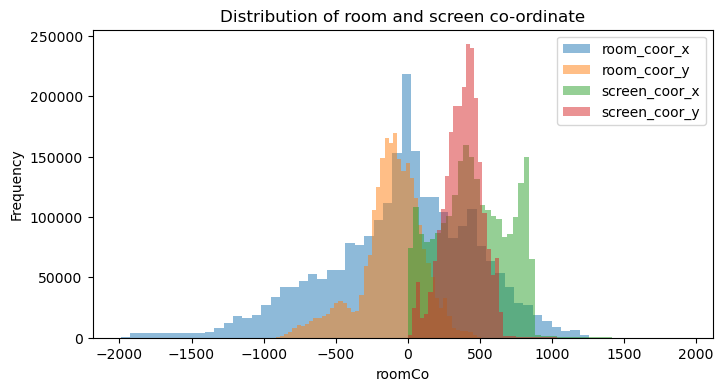

In [116]:
plt.figure(figsize=(8, 4))

plt.hist(train['room_coor_x'], bins=50, alpha=0.5, label='room_coor_x')
plt.hist(train['room_coor_y'], bins=50, alpha=0.5, label='room_coor_y')
plt.hist(train['screen_coor_x'], bins=50, alpha=0.5, label='screen_coor_x')
plt.hist(train['screen_coor_y'], bins=50, alpha=0.5, label='screen_coor_y')
plt.xlabel('roomCo')
plt.ylabel('Frequency')
plt.title('Distribution of room and screen co-ordinate')
plt.legend()
plt.show()

<AxesSubplot:>

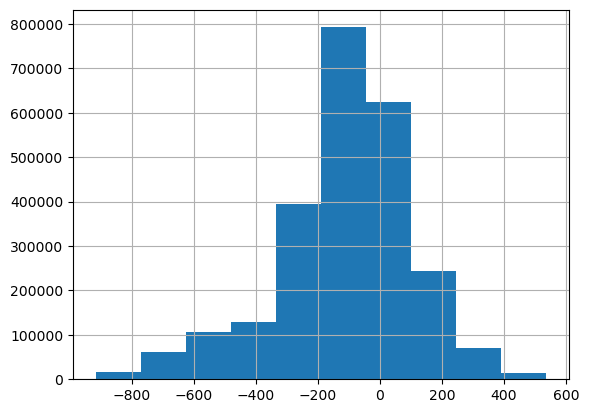

In [96]:
train.room_coor_y.hist()

<AxesSubplot:>

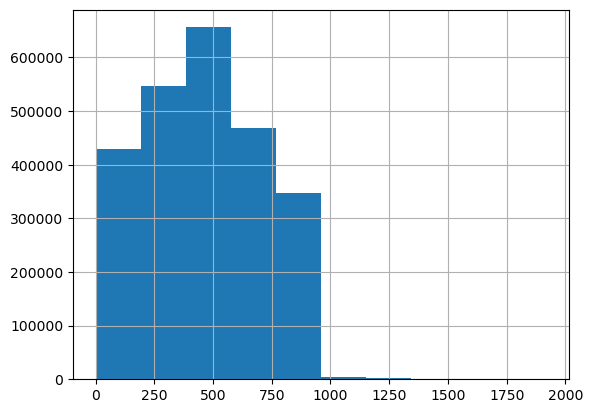

In [98]:
train.screen_coor_x.hist()

<AxesSubplot:>

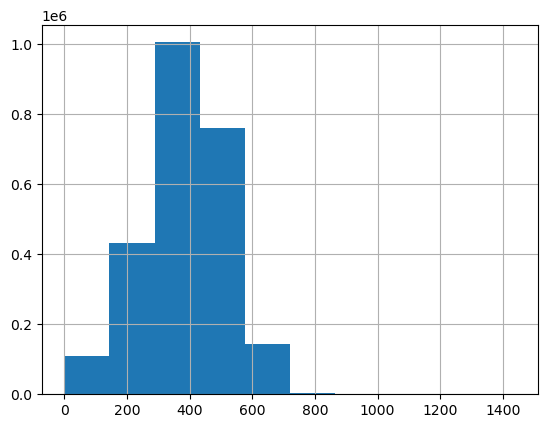

In [99]:
train.screen_coor_y.hist()

In [110]:
# min and max value
li=['room_coor_x','screen_coor_x','room_coor_y','screen_coor_y']
for i in li :
    print(i, "          min value :",round(train[i].min(),2), "   max value. :", round(train[i].max(),2), "   mean. :", round(train[i].mean(),2))    

room_coor_x           min value : -1991.22    max value. : 1257.35    mean. : -54.2
screen_coor_x           min value : 0.0    max value. : 1919.0    mean. : 456.01
room_coor_y           min value : -916.35    max value. : 536.74    mean. : -113.77
screen_coor_y           min value : 0.0    max value. : 1440.0    mean. : 382.5


In [8]:
#print(train.isnull().sum() ,
train.isnull().sum()*100/len(train)

session_id         0.000000
index              0.000000
elapsed_time       0.000000
event_name         0.000000
name               0.000000
level              0.000000
page              97.788421
room_coor_x        8.561090
room_coor_y        8.561090
screen_coor_x      8.561090
screen_coor_y      8.561090
hover_duration    91.703534
text              64.147298
fqid              31.462962
room_fqid          0.000000
text_fqid         64.147037
fullscreen         0.000000
hq                 0.000000
music              0.000000
level_group        0.000000
dtype: float64

In [9]:
targets = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]) )
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
print( targets.shape )
targets.head()

(424116, 4)


,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


In [14]:
CATS = ['event_name', 'fqid', 'room_fqid', 'text', 'text_fqid','name']
NUMS = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']
EVENTS = ['navigate_click','person_click','cutscene_click','object_click',
          'map_hover','notification_click','map_click','observation_click',
          'checkpoint']

In [ ]:
just coulmn name 

session_id         
index              

elapsed_time       

event_name        
name               
level              
page              
room_coor_x        
room_coor_y        
screen_coor_x      
screen_coor_y      
hover_duration    
text              
fqid              
room_fqid          
text_fqid         
fullscreen         
hq                 
music              
level_group        

In [15]:
def listunique(list):
    for i in list:
        print("Unique value for", i , " is  :" , train[i].nunique())
        print( train[i].value_counts())
        print("------------------------------------")

In [16]:
listunique(CATS)

Unique value for event_name  is  : 11
navigate_click        1151606
person_click           606658
cutscene_click         268843
object_click           227641
object_hover           117460
map_hover              105233
notification_click      64639
notebook_click          59363
map_click               53423
observation_click       22222
checkpoint               7103
Name: event_name, dtype: int64
------------------------------------
Unique value for fqid  is  : 127
worker           188557
gramps           112926
archivist        112693
toentry           80863
wells             79085
                  ...  
block_tomap1        197
block_badge_2       136
need_glasses        133
fox                  79
block_1               7
Name: fqid, Length: 127, dtype: int64
------------------------------------
Unique value for room_fqid  is  : 19
tunic.historicalsociety.entry              368064
tunic.wildlife.center                      303559
tunic.historicalsociety.cage               233894
tunic

In [17]:
listunique(NUMS)

Unique value for elapsed_time  is  : 1785689
0          2357
64450        13
8016         12
1615         12
515482       11
           ... 
8291070       1
8290625       1
8289787       1
8289325       1
1773917       1
Name: elapsed_time, Length: 1785689, dtype: int64
------------------------------------
Unique value for level  is  : 23
18    364654
6     215421
21    213978
11    206102
7     131726
16    128352
15    125723
19    121398
9     119692
17    118647
3     117995
20    115643
2      99217
8      89708
13     81745
1      72083
5      69155
0      68802
14     52298
10     46756
22     44680
4      41862
12     38554
Name: level, dtype: int64
------------------------------------
Unique value for page  is  : 7
1.0    10650
5.0    10194
6.0     9174
4.0     8655
0.0     8295
3.0     6790
2.0     5605
Name: page, dtype: int64
------------------------------------
Unique value for room_coor_x  is  : 1961769
 427.725528    499
 431.725528    488
 421.725528    465
 433.725528 

In [ ]:
for c in EVENTS: 
        train[c] = (train.event_name == c).astype('int8')

In [ ]:
train.head()

In [18]:
def feature_engineer(train):
    
    dfs = []
    for c in CATS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = tmp.name + '_mean'
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    for c in EVENTS: 
        train[c] = (train.event_name == c).astype('int8')
    for c in EVENTS + ['elapsed_time']:
        tmp = train.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    train = train.drop(EVENTS,axis=1)
        
    df = pd.concat(dfs,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [19]:
feature_engineer(train)

,level_group,event_name_nunique,fqid_nunique,room_fqid_nunique,text_nunique,text_fqid_nunique,name_nunique,elapsed_time_mean,level_mean,page_mean,...,navigate_click_sum,person_click_sum,cutscene_click_sum,object_click_sum,map_hover_sum,notification_click_sum,map_click_sum,observation_click_sum,checkpoint_sum,elapsed_time_sum
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,30,7,56,17,3,8.579356e+04,1.945455,-1.000000,...,81.0,22.0,28.0,11.0,4.0,8,2.0,4,1,14155937
20090312431273200,13-22,10,49,12,168,35,3,1.040601e+06,17.402381,-1.000000,...,170.0,123.0,60.0,20.0,14.0,10,6.0,3,1,437052322
20090312431273200,5-12,10,39,11,124,24,3,3.572052e+05,8.054054,-1.000000,...,103.0,104.0,12.0,28.0,9.0,9,8.0,1,1,105732736
20090312433251036,0-4,11,22,6,49,11,4,9.763342e+04,1.870504,0.000000,...,49.0,18.0,36.0,15.0,3.0,5,3.0,2,1,13571045
20090312433251036,13-22,11,73,16,183,43,6,2.498852e+06,17.762529,5.100000,...,637.0,145.0,65.0,83.0,186.0,14,45.0,5,1,3241011333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20110316284487930,13-22,10,51,15,202,36,3,1.674641e+06,17.843985,-1.000000,...,244.0,131.0,77.0,10.0,34.0,6,15.0,5,1,890909169
20110316284487930,5-12,11,52,13,155,30,4,6.035096e+05,8.080586,2.500000,...,254.0,155.0,12.0,37.0,14.0,9,21.0,5,1,329516240
20110316334583480,0-4,11,29,7,61,18,4,1.084263e+05,2.084000,1.000000,...,122.0,21.0,49.0,28.0,1.0,12,3.0,5,1,27106585


In [23]:
%%time

# PROCESS TRAIN DATA IN PIECES
all_pieces = []
print(f'Processing train as {PIECES} pieces to avoid memory error... ')
for k in range(PIECES):
    print(k,', ',end='')
    SKIPS = 0
    if k>0: SKIPS = range(1,skips[k]+1)
    train = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv',
                        nrows=reads[k], skiprows=SKIPS)
    df = feature_engineer(train)
    all_pieces.append(df)
    
# CONCATENATE ALL PIECES
print('\n')
del train; gc.collect()
df = pd.concat(all_pieces, axis=0)
print('Shape of all train data after feature engineering:', df.shape )
df.head()

Processing train as 10 pieces to avoid memory error... 
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 

Shape of all train data after feature engineering: (70686, 33)
CPU times: user 4min 57s, sys: 10.9 s, total: 5min 7s
Wall time: 5min 8s


,level_group,event_name_nunique,fqid_nunique,room_fqid_nunique,text_nunique,text_fqid_nunique,name_nunique,elapsed_time_mean,level_mean,page_mean,...,navigate_click_sum,person_click_sum,cutscene_click_sum,object_click_sum,map_hover_sum,notification_click_sum,map_click_sum,observation_click_sum,checkpoint_sum,elapsed_time_sum
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,30,7,56,17,3,8.579356e+04,1.945455,-1.0,...,81.0,22.0,28.0,11.0,4.0,8,2.0,4,1,14155937
20090312431273200,13-22,10,49,12,168,35,3,1.040601e+06,17.402381,-1.0,...,170.0,123.0,60.0,20.0,14.0,10,6.0,3,1,437052322
20090312431273200,5-12,10,39,11,124,24,3,3.572052e+05,8.054054,-1.0,...,103.0,104.0,12.0,28.0,9.0,9,8.0,1,1,105732736
20090312433251036,0-4,11,22,6,49,11,4,9.763342e+04,1.870504,0.0,...,49.0,18.0,36.0,15.0,3.0,5,3.0,2,1,13571045
20090312433251036,13-22,11,73,16,183,43,6,2.498852e+06,17.762529,5.1,...,637.0,145.0,65.0,83.0,186.0,14,45.0,5,1,3241011333


In [24]:
FEATURES = [c for c in df.columns if c != 'level_group']
print('We will train with', len(FEATURES) ,'features')
ALL_USERS = df.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 32 features
We will train with 23562 users info


In [27]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    xgb_params = {
    'objective' : 'binary:logistic',
    'eval_metric':'logloss',
    'learning_rate': 0.05,
    'max_depth': 4,
    'n_estimators': 1000,
    'early_stopping_rounds': 50,
    'tree_method':'hist',
    'subsample':0.8,
    'colsample_bytree': 0.4,
    'use_label_encoder' : False}
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL        
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[ (valid_x[FEATURES].astype('float32'), valid_y['correct']) ],
                verbose=0)
        print(f'{t}({clf.best_ntree_limit}), ',end='')
        
        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        
    print()

#########################
### Fold 1
#########################
1(148), 2(109), 3(107), 4(210), 5(186), 6(236), 7(93), 8(95), 9(114), 10(183), 11(114), 12(119), 13(204), 14(274), 15(156), 16(61), 17(56), 18(165), 
#########################
### Fold 2
#########################
1(139), 2(172), 3(149), 4(206), 5(134), 6(131), 7(130), 8(64), 9(170), 10(135), 11(150), 12(127), 13(93), 14(228), 15(147), 16(118), 17(107), 18(158), 
#########################
### Fold 3
#########################
1(166), 2(130), 3(129), 4(251), 5(142), 6(150), 7(134), 8(65), 9(189), 10(120), 11(80), 12(85), 13(111), 14(198), 15(248), 16(67), 17(112), 18(153), 
#########################
### Fold 4
#########################
1(144), 2(132), 3(95), 4(220), 5(155), 6(176), 7(125), 8(78), 9(127), 10(108), 11(104), 12(101), 13(189), 14(290), 15(309), 16(58), 17(58), 18(134), 
#########################
### Fold 5
#########################
1(217), 2(167), 3(172), 4(251), 5(164), 6(119), 7(181), 8(60), 9(92), 10(150), 11(8

In [30]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [31]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

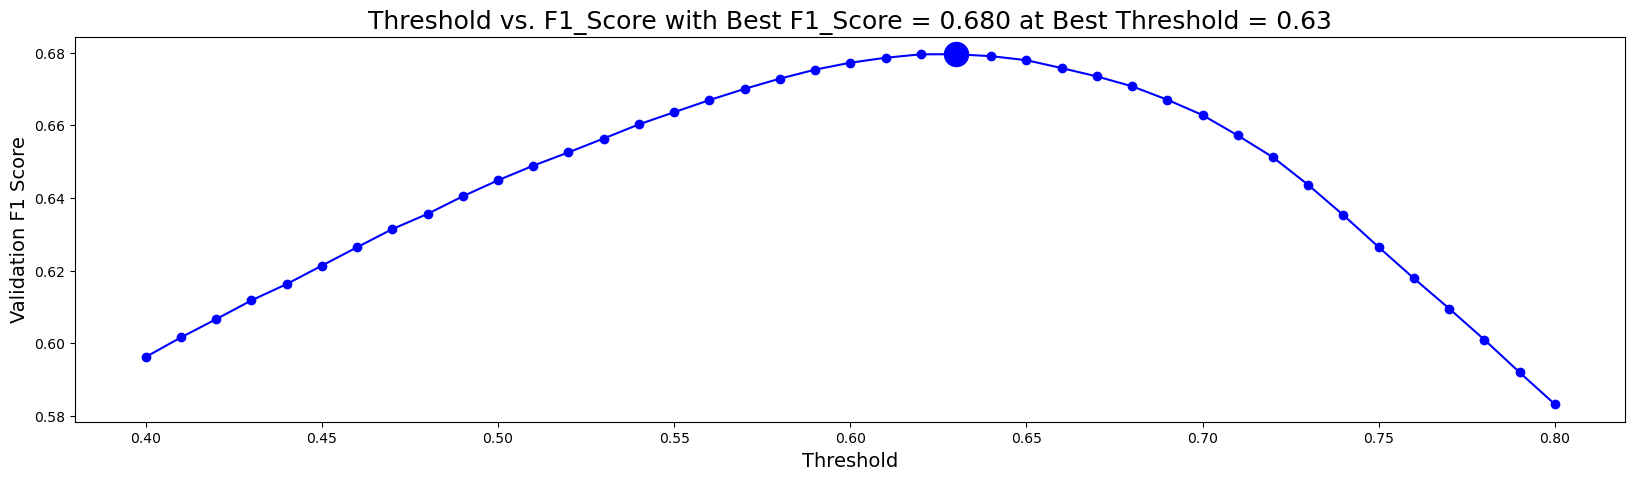

In [32]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()



In [33]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.6061746573824558
Q1: F1 = 0.49464879356568364
Q2: F1 = 0.48854795029205306
Q3: F1 = 0.6230597963175797
Q4: F1 = 0.5803444735294829
Q5: F1 = 0.6117064886511406
Q6: F1 = 0.5849321838044402
Q7: F1 = 0.5388985924516149
Q8: F1 = 0.6023629879245649
Q9: F1 = 0.5224601763676413
Q10: F1 = 0.5904248103519452
Q11: F1 = 0.4973065731246857
Q12: F1 = 0.43669965192646243
Q13: F1 = 0.6122030260843667
Q14: F1 = 0.5136281826267983
Q15: F1 = 0.466186009001992
Q16: F1 = 0.5426863737689613
Q17: F1 = 0.49150439591898165
==> Overall F1 = 0.6795913435352503


In [34]:
# IMPORT KAGGLE API
import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

# CLEAR MEMORY
import gc
del targets, df, oof, true
_ = gc.collect()

In [35]:
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for (test, sample_submission) in iter_test:
    
    # FEATURE ENGINEER TEST DATA
    df = feature_engineer(test)
    
    # INFER TEST DATA
    grp = test.level_group.values[0]
    a,b = limits[grp]
    for t in range(a,b):
        clf = models[f'{grp}_{t}']
        p = clf.predict_proba(df[FEATURES].astype('float32'))[0,1]
        mask = sample_submission.session_id.str.contains(f'q{t}')
        sample_submission.loc[mask,'correct'] = int( p > best_threshold )
    
    env.predict(sample_submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


In [36]:
df = pd.read_csv('submission.csv')
print( df.shape )
df.head()

(54, 2)


,session_id,correct
0,20090109393214576_q1,1
1,20090109393214576_q2,1
2,20090109393214576_q3,1
3,20090109393214576_q4,1
4,20090109393214576_q5,0


In [37]:
print(df.correct.mean())

0.5740740740740741
